## Peak-Base, raw SCR value

### Phase 1 

In [18]:
import os

path = '/Volumes/Seagate Desktop Drive/NARSAD/SCR'
os.chdir(path)

import pandas as pd
import numpy as np

# Parameters
trialnumber = range(1, 25)  # Can adjust to first half of trials: range(1, 13)
excludeparticipants = 1  # Set to 0 to include all participants
rejtrials_threshold = 24  # Adjust the threshold as needed

# Load the table
peakstatstable = pd.read_csv('peak_stats_table-phase1.csv')

# Extract unique participant IDs and trial types
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Group data by participant
participant_groups = peakstatstable.groupby('sid')
dat = []

for participant_id in participants:
    data = participant_groups.get_group(participant_id)
    subject_data = {'subID': participant_id}

    # Process data if there are 24 trials
    if len(data) == 24:
        phase1_data = data[data['stNum'].isin(trialnumber)]

        # Rejected trials (based on "Publication recommendations for electrodermal measurements")
        rejTrials = phase1_data[phase1_data['phaBase2Peak'] < 0].index
        phase1_data.loc[rejTrials, 'phaBase2Peak'] = 0  # Mark non-response trials as 0

        subject_data['rejTrials1'] = len(rejTrials)

        # Separate data by stim type
        stim_groups = phase1_data.groupby('stTy')

        try:
            # Calculate mean, SE, and count for CSS, CSR, and CS-
            css_data = stim_groups.get_group('CS+S')
            subject_data['meanCSS1'] = css_data['phaBase2Peak'].mean()
            subject_data['seCSS1'] = css_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSS1'] = len(css_data)

            csr_data = stim_groups.get_group('CS+R')
            subject_data['meanCSR1'] = csr_data['phaBase2Peak'].mean()
            subject_data['seCSR1'] = csr_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSR1'] = len(csr_data)

            csminus_data = stim_groups.get_group('CS-')
            subject_data['meanCSminus1'] = csminus_data['phaBase2Peak'].mean()
            subject_data['seCSminus1'] = csminus_data['phaBase2Peak'].std() / np.sqrt(len(css_data))
            subject_data['nCSminus1'] = len(csminus_data)

        except KeyError:
            print(f"Missing stim type data for participant {participant_id}")
        
    dat.append(subject_data)

# Convert to a DataFrame if you need a structured output
dat_df = pd.DataFrame(dat)
print(dat_df)


    subID  rejTrials1  meanCSS1    seCSS1  nCSS1  meanCSR1    seCSR1  nCSR1  \
0    N101           4  0.034000  0.020075      8  0.010125  0.007352      8   
1    N102           0  0.003625  0.001558      8  0.000875  0.000295      8   
2    N103           1  0.117500  0.020816      8  0.132125  0.025778      8   
3    N104           5  0.001625  0.000944      8  0.001125  0.000581      8   
4    N105           2  0.004625  0.001945      8  0.001625  0.000981      8   
..    ...         ...       ...       ...    ...       ...       ...    ...   
99   N255           6  0.001000  0.000681      8  0.001250  0.000750      8   
100  N257           4  0.031875  0.010315      8  0.041125  0.021445      8   
101  N258           0  0.034000  0.006980      8  0.029000  0.007533      8   
102  N259           2  0.015000  0.004706      8  0.020875  0.008941      8   
103  N260           1  0.081750  0.025366      8  0.068750  0.014820      8   

     meanCSminus1  seCSminus1  nCSminus1  
0       

#### CSR and CSS kept separate 

In [ ]:
# intercept included cs- data, control data, placebo data see specific effect of drug, css, csr, etc. 

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 'CSR', 
    'meanCSS1': 'CSS', 
    'meanCSminus1': 'CSminus'
})

long_data['stim_type'] = long_data['stim_type'].astype('category')
long_data['stim_type'] = long_data['stim_type'].cat.reorder_categories(['CSminus', 'CSR', 'CSS'], ordered=True)

# Model formula including main effect of stim_type
model_formula = 'response ~ C(patient_group) + C(drug) + C(stim_type) + C(gender)'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


In [178]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 1, 
    'meanCSS1': 2, 
    'meanCSminus1': 3
})

# Specify the model without intercept
model_formula = 'response ~ patient_group * stim_type + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.627
Date:                Fri, 01 Nov 2024   Prob (F-statistic):             0.0347
Time:                        12:36:24   Log-Likelihood:                -326.29
No. Observations:                 312   AIC:                             662.6
Df Residuals:                     307   BIC:                             681.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60532/4197659941.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


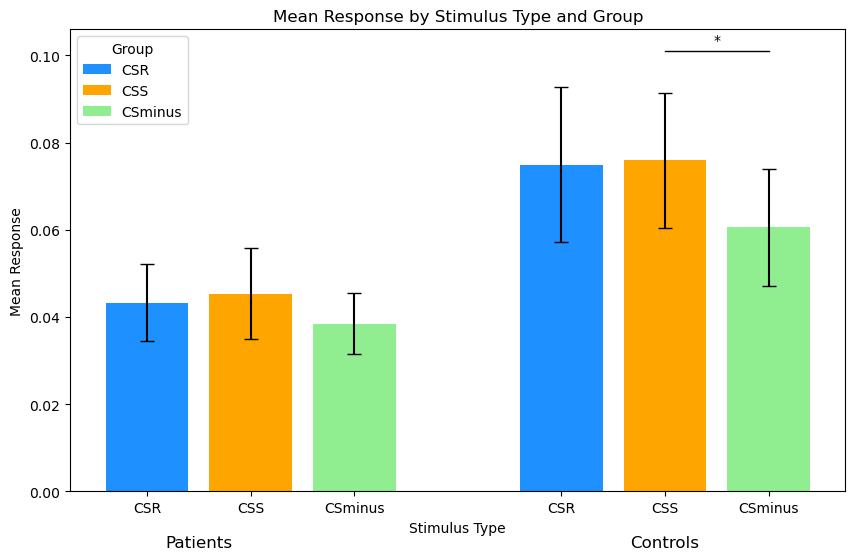

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 'CSR', 
    'meanCSS1': 'CSS', 
    'meanCSminus1': 'CSminus'
})

# Calculate means and errors
group_means = long_data.groupby(['patient_group', 'stim_type'])['response'].mean().reset_index()
group_sems = long_data.groupby(['patient_group', 'stim_type'])['response'].sem().reset_index()

# Set up custom x positions for the bars (grouped with a gap between patients and controls)
x_positions = {
    ('patient', 'CSR'): 0, ('patient', 'CSS'): 1, ('patient', 'CSminus'): 2,
    ('control', 'CSR'): 4, ('control', 'CSS'): 5, ('control', 'CSminus'): 6
}

# Map x positions to data
group_means['x'] = group_means.apply(lambda row: x_positions[(row['patient_group'], row['stim_type'])], axis=1)
group_sems['x'] = group_means['x']

# Define colors for each stimulus type
stimulus_colors = {
    'CSR': 'dodgerblue',
    'CSS': 'orange',
    'CSminus': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(10, 6))

for group in ['patient', 'control']:
    for stim in ['CSR', 'CSS', 'CSminus']:
        group_data = group_means[(group_means['patient_group'] == group) & (group_means['stim_type'] == stim)]
        group_errors = group_sems[(group_sems['patient_group'] == group) & (group_sems['stim_type'] == stim)]
        plt.bar(group_data['x'], group_data['response'], 
                color=stimulus_colors[stim], 
                label=stim if group == 'patient' else "",  # Label only for patients
                yerr=group_errors['response'], capsize=5)

# Add significance markers
def add_significance_markers(ax, comparisons, y_offset=0.02, bar_height=0.02):
    for (group1, stim1), (group2, stim2) in comparisons:
        if group1 == group2:
            # Paired t-test within the same group
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_rel(data1['response'], data2['response'])
        else:
            # Independent t-test between groups
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group2) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_ind(data1['response'], data2['response'], equal_var=False)
        
        if result.pvalue < 0.05:  # Customize significance level if needed
            x1 = x_positions[(group1, stim1)]
            x2 = x_positions[(group2, stim2)]
            max_y = group_means['response'].max() + 0.025  # Adjust this if needed
            ax.plot([x1, x2], [max_y, max_y], 'k-', lw=1)
            ax.text((x1 + x2) / 2, max_y + 0.001, '*', ha='center', va='bottom')

# Define comparisons
comparisons = [
    (('patient', 'CSR'), ('patient', 'CSS')),   # Patient CSR vs CSS
    (('patient', 'CSR'), ('patient', 'CSminus')),  # Patient CSR vs CSminus
    (('patient', 'CSS'), ('patient', 'CSminus')),  # Patient CSS vs CSminus
    (('control', 'CSR'), ('control', 'CSS')),   # Control CSR vs CSS
    (('control', 'CSR'), ('control', 'CSminus')),  # Control CSR vs CSminus
    (('control', 'CSS'), ('control', 'CSminus')),  # Control CSS vs CSminus
    (('patient', 'CSR'), ('control', 'CSR')),    # Between-group CSR
    (('patient', 'CSS'), ('control', 'CSS')),    # Between-group CSS
    (('patient', 'CSminus'), ('control', 'CSminus')) # Between-group CSminus
]

add_significance_markers(plt.gca(), comparisons)
# Add x-axis labels to indicate groups
plt.text(0.5, -0.01, 'Patients', ha='center', va='top', fontsize=12)
plt.text(5, -0.01, 'Controls', ha='center', va='top', fontsize=12)

# Labeling and finalizing plot
plt.xticks([0, 1, 2, 4, 5, 6], ['CSR', 'CSS', 'CSminus', 'CSR', 'CSS', 'CSminus'])
plt.xlabel('Stimulus Type')
plt.ylabel('Mean Response')
plt.title('Mean Response by Stimulus Type and Group')
plt.legend(title='Group')
plt.show()


#### CS+ vs CS-

In [61]:
## treating CSR and CSS as the same categorical condition 

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)  # 1 for patient, 0 for control
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Combine CSR and CSS into a single variable called CS+
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 'CS+',  # Combine CSR
    'meanCSS1': 'CS+',  # Combine CSS
    'meanCSminus1': 'CSminus'  # Keep CSminus as is
})

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].astype('category')

# Specify the model without intercept
model_formula = 'response ~ patient_group * stim_type + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.847
Date:                Thu, 31 Oct 2024   Prob (F-statistic):             0.0242
Time:                        14:03:35   Log-Likelihood:                 304.33
No. Observations:                 312   AIC:                            -598.7
Df Residuals:                     307   BIC:                            -580.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [64]:
# averaging CSR and CSS into CS+ 

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)  # 1 for patient, 0 for control
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Calculate the mean of CSR and CSS for each subject and create a new column for CS+
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Reshape data to stack CS_plus and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['CS_plus', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'CS_plus': 'CS+', 
    'meanCSminus1': 'CSminus'
})

# Map stim_type to categorical type
long_data['stim_type'] = long_data['stim_type'].astype('category')

# Specify the model without intercept
model_formula = 'response ~ patient_group * stim_type + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.994
Date:                Thu, 31 Oct 2024   Prob (F-statistic):             0.0967
Time:                        14:04:21   Log-Likelihood:                 214.37
No. Observations:                 208   AIC:                            -418.7
Df Residuals:                     203   BIC:                            -402.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

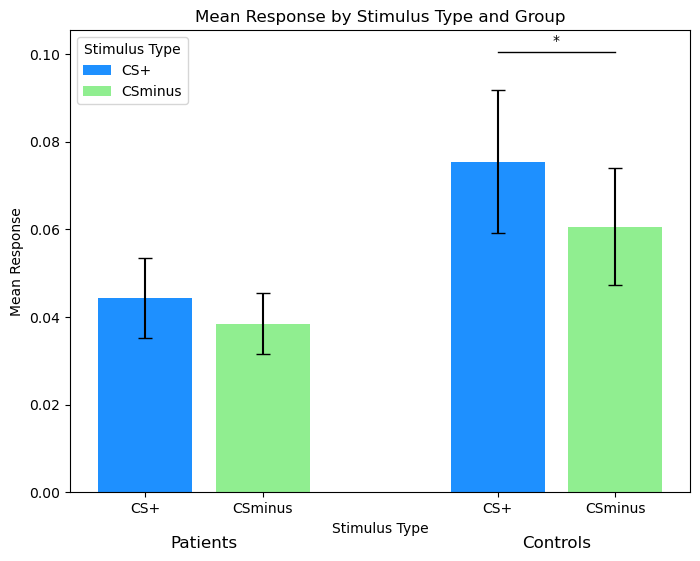

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Calculate the mean of CSR and CSS for each subject to create CS+
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Reshape data to stack CS_plus and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group'], 
                    value_vars=['CS_plus', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'CS_plus': 'CS+', 
    'meanCSminus1': 'CSminus'
})

# Calculate means and errors
group_means = long_data.groupby(['patient_group', 'stim_type'])['response'].mean().reset_index()
group_sems = long_data.groupby(['patient_group', 'stim_type'])['response'].sem().reset_index()

# Set up custom x positions for the bars (grouped with a gap between patients and controls)
x_positions = {
    ('patient', 'CS+'): 0, ('patient', 'CSminus'): 1,
    ('control', 'CS+'): 3, ('control', 'CSminus'): 4
}

# Map x positions to data
group_means['x'] = group_means.apply(lambda row: x_positions[(row['patient_group'], row['stim_type'])], axis=1)
group_sems['x'] = group_means['x']

# Define colors for each stimulus type
stimulus_colors = {
    'CS+': 'dodgerblue',
    'CSminus': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(8, 6))

for group in ['patient', 'control']:
    for stim in ['CS+', 'CSminus']:
        group_data = group_means[(group_means['patient_group'] == group) & (group_means['stim_type'] == stim)]
        group_errors = group_sems[(group_sems['patient_group'] == group) & (group_sems['stim_type'] == stim)]
        plt.bar(group_data['x'], group_data['response'], 
                color=stimulus_colors[stim], 
                label=stim if group == 'patient' else "",  # Label only for patients
                yerr=group_errors['response'], capsize=5)

# Add significance markers
def add_significance_markers(ax, comparisons, y_offset=0.02, bar_height=0.02):
    for (group1, stim1), (group2, stim2) in comparisons:
        if group1 == group2:
            # Paired t-test within the same group
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_rel(data1['response'], data2['response'])
        else:
            # Independent t-test between groups
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group2) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_ind(data1['response'], data2['response'], equal_var=False)
        
        if result.pvalue < 0.05:  # Customize significance level if needed
            x1 = x_positions[(group1, stim1)]
            x2 = x_positions[(group2, stim2)]
            max_y = group_means['response'].max() + 0.025  # Adjust this if needed
            ax.plot([x1, x2], [max_y, max_y], 'k-', lw=1)
            ax.text((x1 + x2) / 2, max_y + 0.001, '*', ha='center', va='bottom')

# Define comparisons
comparisons = [
    (('patient', 'CS+'), ('patient', 'CSminus')),   # Patient CS+ vs CSminus
    (('control', 'CS+'), ('control', 'CSminus')),   # Control CS+ vs CSminus
    (('patient', 'CS+'), ('control', 'CS+')),       # Between-group CS+
    (('patient', 'CSminus'), ('control', 'CSminus')) # Between-group CSminus
]

add_significance_markers(plt.gca(), comparisons)

# Labeling and finalizing plot
plt.xticks([0, 1, 3, 4], ['CS+', 'CSminus', 'CS+', 'CSminus'])
plt.xlabel('Stimulus Type')
plt.ylabel('Mean Response')
plt.title('Mean Response by Stimulus Type and Group')

# Add x-axis labels to indicate groups
plt.text(0.5, -0.01, 'Patients', ha='center', va='top', fontsize=12)
plt.text(3.5, -0.01, 'Controls', ha='center', va='top', fontsize=12)

plt.legend(title='Stimulus Type')
plt.show()


### Phase 2 / 3 - averaged across the whole phase

In [75]:
import pandas as pd
import numpy as np

# Parameters to adjust:
trialnumber2 = range(1, 25)  # Adjust this range to analyze specific trials (e.g., first half = range(1, 13))
trialnumber3 = range(25, 49) # Adjust this range for phase 3 analysis (e.g., range(25, 37) for first half)

excludeparticipants = 1  # Set to 0 to include all subjects; if set to 1, participants with rejected trials >= rejtrials_threshold are excluded
rejtrials_threshold = 24  # Threshold for trial rejection; adjust according to trial number

# Load data
peakstatstable = pd.read_csv('peak_stats_table-phase2.3.csv')
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Separate data by participant, phase, and stim type
grouped_data = peakstatstable.groupby('sid')
dat = []

for participant in participants:
    data = grouped_data.get_group(participant)
    participant_data = {'subID': participant}

    # Ensuring consistent data structure
    if data.shape[0] == 48:
        
        # Phase 2 processing: stims numbered in trialnumber2
        phase2_data = data[data['stNum'].isin(trialnumber2)]
        rejTrials = phase2_data[phase2_data['phaBase2Peak'] < 0.02].index
        phase2_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials2'] = len(rejTrials)

        # Separate out stim types
        data2 = {key: value for key, value in phase2_data.groupby('stTy')}
        try:
            participant_data['meanCSS2'] = data2['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS2'] = data2['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data2['CS+S']))
            participant_data['nCSS2'] = len(data2['CS+S'])
            participant_data['meanCSR2'] = data2['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR2'] = data2['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data2['CS+R']))
            participant_data['nCSR2'] = len(data2['CS+R'])
            participant_data['meanCSminus2'] = data2['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus2'] = data2['CS-']['phaBase2Peak'].std() / np.sqrt(len(data2['CS-']))
            participant_data['nCSminus2'] = len(data2['CS-'])
        except KeyError:
            # Handle missing data if any stimulus type is not present for a participant
            print(f"Missing data for participant {participant} in Phase 2.")

        # Phase 3 processing: stims numbered in trialnumber3
        phase3_data = data[data['stNum'].isin(trialnumber3)]
        rejTrials = phase3_data[phase3_data['phaBase2Peak'] < 0.02].index
        phase3_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials3'] = len(rejTrials)

        # Separate out stim types
        data3 = {key: value for key, value in phase3_data.groupby('stTy')}
        try:
            participant_data['meanCSS3'] = data3['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS3'] = data3['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data3['CS+S']))
            participant_data['nCSS3'] = len(data3['CS+S'])
            participant_data['meanCSR3'] = data3['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR3'] = data3['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data3['CS+R']))
            participant_data['nCSR3'] = len(data3['CS+R'])
            participant_data['meanCSminus3'] = data3['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus3'] = data3['CS-']['phaBase2Peak'].std() / np.sqrt(len(data3['CS-']))
            participant_data['nCSminus3'] = len(data3['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 3.")

    # Add participant data to the main list
    dat.append(participant_data)

# Convert dat list to a DataFrame for easier viewing and export
dat_df = pd.DataFrame(dat)
print(dat_df)


    subID  rejTrials2  meanCSS2    seCSS2  nCSS2  meanCSR2    seCSR2  nCSR2  \
0    N101           3  0.020250  0.002957      8  0.031750  0.010813      8   
1    N103           4  0.032625  0.003105      8  0.024875  0.013315      8   
2    N104           4  0.016125  0.003543      8  0.016000  0.003505      8   
3    N105           5  0.018000  0.003973      8  0.020000  0.002928      8   
4    N106           0  0.025000  0.001000      8  0.027625  0.002104      8   
..    ...         ...       ...       ...    ...       ...       ...    ...   
96   N255           0  0.032500  0.002228      8  0.034625  0.004263      8   
97   N257           3  0.020500  0.002958      8  0.020125  0.002900      8   
98   N258           0  0.029625  0.000885      8  0.029500  0.000945      8   
99   N259           0  0.032250  0.000590      8  0.031375  0.000420      8   
100  N260          11  0.023125  0.009516      8  0.054875  0.022743      8   

     meanCSminus2  seCSminus2  ...  rejTrials3  mea

#### Extinction

In [76]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR2', 'meanCSS2', 'meanCSminus2'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR2': 1, 
    'meanCSS2': 2, 
    'meanCSminus2': 3
})

# Specify the model without intercept
model_formula = 'response ~ patient_group * drug * stim_type + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.074
Date:                Thu, 31 Oct 2024   Prob (F-statistic):              0.381
Time:                        14:44:20   Log-Likelihood:                 448.71
No. Observations:                 303   AIC:                            -879.4
Df Residuals:                     294   BIC:                            -846.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60532/639515244.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


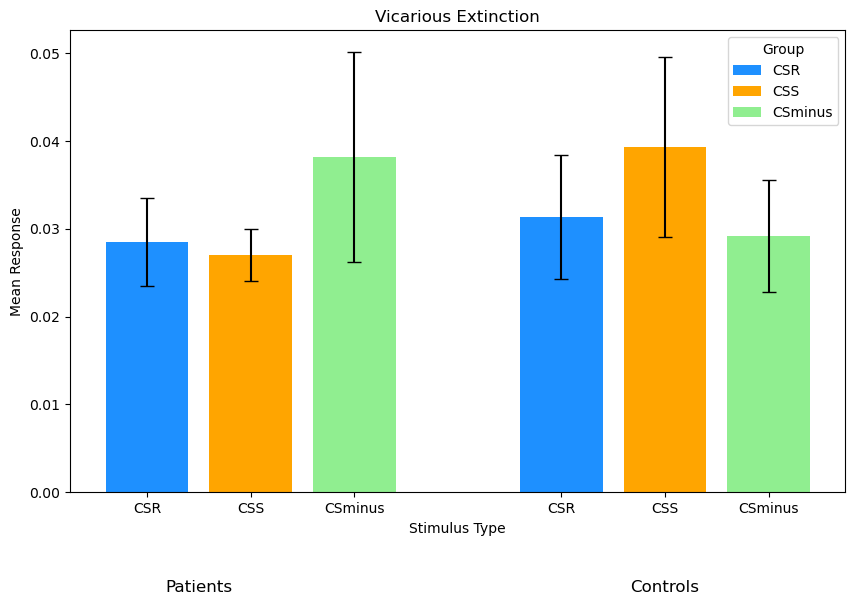

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group'], 
                    value_vars=['meanCSR2', 'meanCSS2', 'meanCSminus2'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR2': 'CSR', 
    'meanCSS2': 'CSS', 
    'meanCSminus2': 'CSminus'
})

# Calculate means and errors
group_means = long_data.groupby(['patient_group', 'stim_type'])['response'].mean().reset_index()
group_sems = long_data.groupby(['patient_group', 'stim_type'])['response'].sem().reset_index()

# Set up custom x positions for the bars (grouped with a gap between patients and controls)
x_positions = {
    ('patient', 'CSR'): 0, ('patient', 'CSS'): 1, ('patient', 'CSminus'): 2,
    ('control', 'CSR'): 4, ('control', 'CSS'): 5, ('control', 'CSminus'): 6
}

# Map x positions to data
group_means['x'] = group_means.apply(lambda row: x_positions[(row['patient_group'], row['stim_type'])], axis=1)
group_sems['x'] = group_means['x']

# Define colors for each stimulus type
stimulus_colors = {
    'CSR': 'dodgerblue',
    'CSS': 'orange',
    'CSminus': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(10, 6))

for group in ['patient', 'control']:
    for stim in ['CSR', 'CSS', 'CSminus']:
        group_data = group_means[(group_means['patient_group'] == group) & (group_means['stim_type'] == stim)]
        group_errors = group_sems[(group_sems['patient_group'] == group) & (group_sems['stim_type'] == stim)]
        plt.bar(group_data['x'], group_data['response'], 
                color=stimulus_colors[stim], 
                label=stim if group == 'patient' else "",  # Label only for patients
                yerr=group_errors['response'], capsize=5)

# Add significance markers
def add_significance_markers(ax, comparisons, y_offset=0.02, bar_height=0.02):
    for (group1, stim1), (group2, stim2) in comparisons:
        if group1 == group2:
            # Paired t-test within the same group
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_rel(data1['response'], data2['response'])
        else:
            # Independent t-test between groups
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group2) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_ind(data1['response'], data2['response'], equal_var=False)
        
        if result.pvalue < 0.05:  # Customize significance level if needed
            x1 = x_positions[(group1, stim1)]
            x2 = x_positions[(group2, stim2)]
            max_y = group_means['response'].max() + 0.025  # Adjust this if needed
            ax.plot([x1, x2], [max_y, max_y], 'k-', lw=1)
            ax.text((x1 + x2) / 2, max_y + 0.001, '*', ha='center', va='bottom')

# Define comparisons
comparisons = [
    (('patient', 'CSR'), ('patient', 'CSS')),   # Patient CSR vs CSS
    (('patient', 'CSR'), ('patient', 'CSminus')),  # Patient CSR vs CSminus
    (('patient', 'CSS'), ('patient', 'CSminus')),  # Patient CSS vs CSminus
    (('control', 'CSR'), ('control', 'CSS')),   # Control CSR vs CSS
    (('control', 'CSR'), ('control', 'CSminus')),  # Control CSR vs CSminus
    (('control', 'CSS'), ('control', 'CSminus')),  # Control CSS vs CSminus
    (('patient', 'CSR'), ('control', 'CSR')),    # Between-group CSR
    (('patient', 'CSS'), ('control', 'CSS')),    # Between-group CSS
    (('patient', 'CSminus'), ('control', 'CSminus')) # Between-group CSminus
]

add_significance_markers(plt.gca(), comparisons)
# Add x-axis labels to indicate groups
plt.text(0.5, -0.01, 'Patients', ha='center', va='top', fontsize=12)
plt.text(5, -0.01, 'Controls', ha='center', va='top', fontsize=12)

# Labeling and finalizing plot
plt.xticks([0, 1, 2, 4, 5, 6], ['CSR', 'CSS', 'CSminus', 'CSR', 'CSS', 'CSminus'])
plt.xlabel('Stimulus Type')
plt.ylabel('Mean Response')
plt.title('Vicarious Extinction')
plt.legend(title='Group')
plt.show()


#### Reinstatement

In [82]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR3', 'meanCSS3', 'meanCSminus3'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR3': 1, 
    'meanCSS3': 2, 
    'meanCSminus3': 3
})

# Specify the model without intercept
model_formula = 'response ~ patient_group * drug * stim_type + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9407
Date:                Thu, 31 Oct 2024   Prob (F-statistic):              0.483
Time:                        14:46:51   Log-Likelihood:                 373.67
No. Observations:                 303   AIC:                            -729.3
Df Residuals:                     294   BIC:                            -695.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60532/1701529658.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


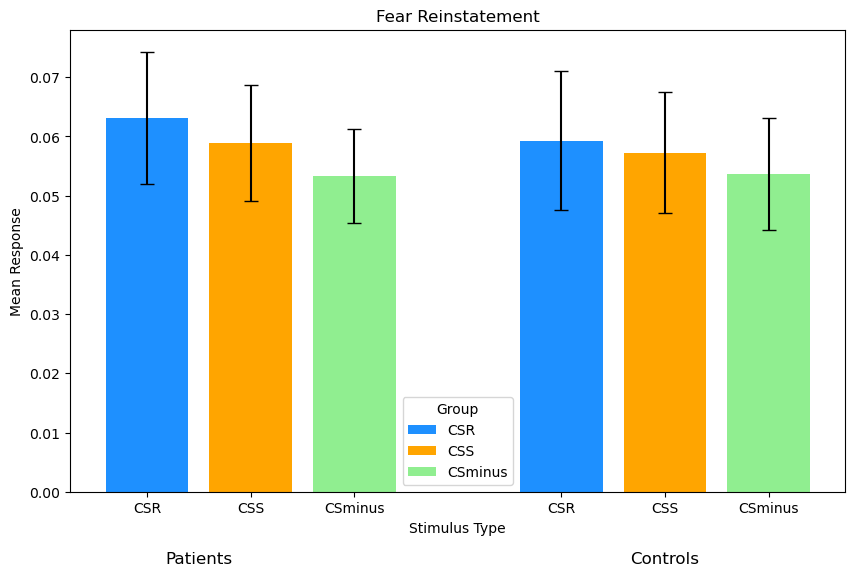

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group'], 
                    value_vars=['meanCSR3', 'meanCSS3', 'meanCSminus3'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR3': 'CSR', 
    'meanCSS3': 'CSS', 
    'meanCSminus3': 'CSminus'
})

# Calculate means and errors
group_means = long_data.groupby(['patient_group', 'stim_type'])['response'].mean().reset_index()
group_sems = long_data.groupby(['patient_group', 'stim_type'])['response'].sem().reset_index()

# Set up custom x positions for the bars (grouped with a gap between patients and controls)
x_positions = {
    ('patient', 'CSR'): 0, ('patient', 'CSS'): 1, ('patient', 'CSminus'): 2,
    ('control', 'CSR'): 4, ('control', 'CSS'): 5, ('control', 'CSminus'): 6
}

# Map x positions to data
group_means['x'] = group_means.apply(lambda row: x_positions[(row['patient_group'], row['stim_type'])], axis=1)
group_sems['x'] = group_means['x']

# Define colors for each stimulus type
stimulus_colors = {
    'CSR': 'dodgerblue',
    'CSS': 'orange',
    'CSminus': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(10, 6))

for group in ['patient', 'control']:
    for stim in ['CSR', 'CSS', 'CSminus']:
        group_data = group_means[(group_means['patient_group'] == group) & (group_means['stim_type'] == stim)]
        group_errors = group_sems[(group_sems['patient_group'] == group) & (group_sems['stim_type'] == stim)]
        plt.bar(group_data['x'], group_data['response'], 
                color=stimulus_colors[stim], 
                label=stim if group == 'patient' else "",  # Label only for patients
                yerr=group_errors['response'], capsize=5)

# Add significance markers
def add_significance_markers(ax, comparisons, y_offset=0.02, bar_height=0.02):
    for (group1, stim1), (group2, stim2) in comparisons:
        if group1 == group2:
            # Paired t-test within the same group
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_rel(data1['response'], data2['response'])
        else:
            # Independent t-test between groups
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group2) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_ind(data1['response'], data2['response'], equal_var=False)
        
        if result.pvalue < 0.05:  # Customize significance level if needed
            x1 = x_positions[(group1, stim1)]
            x2 = x_positions[(group2, stim2)]
            max_y = group_means['response'].max() + 0.025  # Adjust this if needed
            ax.plot([x1, x2], [max_y, max_y], 'k-', lw=1)
            ax.text((x1 + x2) / 2, max_y + 0.001, '*', ha='center', va='bottom')

# Define comparisons
comparisons = [
    (('patient', 'CSR'), ('patient', 'CSS')),   # Patient CSR vs CSS
    (('patient', 'CSR'), ('patient', 'CSminus')),  # Patient CSR vs CSminus
    (('patient', 'CSS'), ('patient', 'CSminus')),  # Patient CSS vs CSminus
    (('control', 'CSR'), ('control', 'CSS')),   # Control CSR vs CSS
    (('control', 'CSR'), ('control', 'CSminus')),  # Control CSR vs CSminus
    (('control', 'CSS'), ('control', 'CSminus')),  # Control CSS vs CSminus
    (('patient', 'CSR'), ('control', 'CSR')),    # Between-group CSR
    (('patient', 'CSS'), ('control', 'CSS')),    # Between-group CSS
    (('patient', 'CSminus'), ('control', 'CSminus')) # Between-group CSminus
]

add_significance_markers(plt.gca(), comparisons)
# Add x-axis labels to indicate groups
plt.text(0.5, -0.01, 'Patients', ha='center', va='top', fontsize=12)
plt.text(5, -0.01, 'Controls', ha='center', va='top', fontsize=12)

# Labeling and finalizing plot
plt.xticks([0, 1, 2, 4, 5, 6], ['CSR', 'CSS', 'CSminus', 'CSR', 'CSS', 'CSminus'])
plt.xlabel('Stimulus Type')
plt.ylabel('Mean Response')
plt.title('Fear Reinstatement')
plt.legend(title='Group')
plt.show()


### Phase 2 / 3 - early vs late (first half vs second half) 

In [86]:
import pandas as pd
import numpy as np

# Parameters to adjust:
trialnumber2_early = range(1, 13)  # Early trials for Phase 2 (1:12)
trialnumber2_late = range(13, 25)   # Late trials for Phase 2 (13:24)
trialnumber3_early = range(25, 37)  # Early trials for Phase 3 (25:36)
trialnumber3_late = range(37, 49)   # Late trials for Phase 3 (37:48)

excludeparticipants = 1  # Set to 0 to include all subjects; if set to 1, participants with rejected trials >= rejtrials_threshold are excluded
rejtrials_threshold = 24  # Threshold for trial rejection; adjust according to trial number

# Load data
peakstatstable = pd.read_csv('peak_stats_table-phase2.3.csv')
participants = peakstatstable['sid'].unique()
trial_types = peakstatstable['stTy'].unique()

# Separate data by participant, phase, and stim type
grouped_data = peakstatstable.groupby('sid')
dat = []

for participant in participants:
    data = grouped_data.get_group(participant)
    participant_data = {'subID': participant}

    # Ensuring consistent data structure
    if data.shape[0] == 48:
        
        # Phase 2 processing: stims numbered in trialnumber2
        phase2_data = data[data['stNum'].isin(range(1, 25))]
        rejTrials = phase2_data[phase2_data['phaBase2Peak'] < 0.02].index
        phase2_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials2'] = len(rejTrials)

        # Separate out stim types for early trials
        phase2_early_data = phase2_data[phase2_data['stNum'].isin(trialnumber2_early)]
        data2_early = {key: value for key, value in phase2_early_data.groupby('stTy')}
        
        # Calculate means and SE for early trials
        try:
            participant_data['meanCSS2_early'] = data2_early['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS2_early'] = data2_early['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data2_early['CS+S']))
            participant_data['nCSS2_early'] = len(data2_early['CS+S'])
            participant_data['meanCSR2_early'] = data2_early['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR2_early'] = data2_early['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data2_early['CS+R']))
            participant_data['nCSR2_early'] = len(data2_early['CS+R'])
            participant_data['meanCSminus2_early'] = data2_early['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus2_early'] = data2_early['CS-']['phaBase2Peak'].std() / np.sqrt(len(data2_early['CS-']))
            participant_data['nCSminus2_early'] = len(data2_early['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 2 early trials.")

        # Separate out stim types for late trials
        phase2_late_data = phase2_data[phase2_data['stNum'].isin(trialnumber2_late)]
        data2_late = {key: value for key, value in phase2_late_data.groupby('stTy')}
        
        # Calculate means and SE for late trials
        try:
            participant_data['meanCSS2_late'] = data2_late['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS2_late'] = data2_late['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data2_late['CS+S']))
            participant_data['nCSS2_late'] = len(data2_late['CS+S'])
            participant_data['meanCSR2_late'] = data2_late['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR2_late'] = data2_late['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data2_late['CS+R']))
            participant_data['nCSR2_late'] = len(data2_late['CS+R'])
            participant_data['meanCSminus2_late'] = data2_late['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus2_late'] = data2_late['CS-']['phaBase2Peak'].std() / np.sqrt(len(data2_late['CS-']))
            participant_data['nCSminus2_late'] = len(data2_late['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 2 late trials.")

        # Phase 3 processing: stims numbered in trialnumber3
        phase3_data = data[data['stNum'].isin(range(25, 49))]
        rejTrials = phase3_data[phase3_data['phaBase2Peak'] < 0.02].index
        phase3_data.loc[rejTrials, 'phaBase2Peak'] = 0
        participant_data['rejTrials3'] = len(rejTrials)

        # Separate out stim types for early trials
        phase3_early_data = phase3_data[phase3_data['stNum'].isin(trialnumber3_early)]
        data3_early = {key: value for key, value in phase3_early_data.groupby('stTy')}
        
        # Calculate means and SE for early trials
        try:
            participant_data['meanCSS3_early'] = data3_early['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS3_early'] = data3_early['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data3_early['CS+S']))
            participant_data['nCSS3_early'] = len(data3_early['CS+S'])
            participant_data['meanCSR3_early'] = data3_early['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR3_early'] = data3_early['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data3_early['CS+R']))
            participant_data['nCSR3_early'] = len(data3_early['CS+R'])
            participant_data['meanCSminus3_early'] = data3_early['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus3_early'] = data3_early['CS-']['phaBase2Peak'].std() / np.sqrt(len(data3_early['CS-']))
            participant_data['nCSminus3_early'] = len(data3_early['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 3 early trials.")

        # Separate out stim types for late trials
        phase3_late_data = phase3_data[phase3_data['stNum'].isin(trialnumber3_late)]
        data3_late = {key: value for key, value in phase3_late_data.groupby('stTy')}
        
        # Calculate means and SE for late trials
        try:
            participant_data['meanCSS3_late'] = data3_late['CS+S']['phaBase2Peak'].mean()
            participant_data['seCSS3_late'] = data3_late['CS+S']['phaBase2Peak'].std() / np.sqrt(len(data3_late['CS+S']))
            participant_data['nCSS3_late'] = len(data3_late['CS+S'])
            participant_data['meanCSR3_late'] = data3_late['CS+R']['phaBase2Peak'].mean()
            participant_data['seCSR3_late'] = data3_late['CS+R']['phaBase2Peak'].std() / np.sqrt(len(data3_late['CS+R']))
            participant_data['nCSR3_late'] = len(data3_late['CS+R'])
            participant_data['meanCSminus3_late'] = data3_late['CS-']['phaBase2Peak'].mean()
            participant_data['seCSminus3_late'] = data3_late['CS-']['phaBase2Peak'].std() / np.sqrt(len(data3_late['CS-']))
            participant_data['nCSminus3_late'] = len(data3_late['CS-'])
        except KeyError:
            print(f"Missing data for participant {participant} in Phase 3 late trials.")

    # Add participant data to the main list
    dat.append(participant_data)

# Convert dat list to a DataFrame for easier viewing and export
dat_df = pd.DataFrame(dat)
print(dat_df)


    subID  rejTrials2  meanCSS2_early  seCSS2_early  nCSS2_early  \
0    N101           3        0.017800      0.004499            5   
1    N103           4        0.035500      0.004093            4   
2    N104           4        0.014333      0.007172            3   
3    N105           5        0.025333      0.000882            3   
4    N106           0        0.025000      0.002000            3   
..    ...         ...             ...           ...          ...   
96   N255           0        0.031667      0.002404            3   
97   N257           3        0.024333      0.000333            3   
98   N258           0        0.030667      0.001453            3   
99   N259           0        0.030667      0.000333            3   
100  N260          11        0.027667      0.017477            3   

     meanCSR2_early  seCSR2_early  nCSR2_early  meanCSminus2_early  \
0          0.053333      0.025314            3            0.024000   
1          0.022000      0.022000          

#### Extinction 

In [163]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack early and late responses with a time variable
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR2_early', 'meanCSR2_late', 'meanCSS2_early', 'meanCSS2_late', 'meanCSminus2_early', 'meanCSminus2_late'], 
                    var_name='stim_type_time', 
                    value_name='response')

# Split 'stim_type_time' into separate 'stim_type' and 'time' columns
long_data['stim_type'] = long_data['stim_type_time'].str.extract(r'mean(\w+)_')[0]
long_data['time'] = long_data['stim_type_time'].str.extract(r'_(\w+)$')[0].map({'early': 1, 'late': 2})

# Map stim_type to numerical codes
long_data['stim_type'] = long_data['stim_type'].map({
    'CSR2': 1, 
    'CSS2': 2, 
    'CSminus2': 3
})

# Specify the model with time as a main effect
model_formula = 'response ~ patient_group * drug + stim_type + time + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.167
Date:                Fri, 01 Nov 2024   Prob (F-statistic):             0.0446
Time:                        09:50:44   Log-Likelihood:                 815.44
No. Observations:                 606   AIC:                            -1617.
Df Residuals:                     599   BIC:                            -1586.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0491      0

In [143]:
import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx",'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)

# Initialize dictionary to store means and SEs
all_stats = {}

# Calculate means and SEs for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Early stage statistics for CSS2
    mean_early = group_data['meanCSS2_early'].mean()
    se_early = group_data['meanCSS2_early'].sem()
    all_stats[f'CSS_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSS2
    mean_late = group_data['meanCSS2_late'].mean()
    se_late = group_data['meanCSS2_late'].sem()
    all_stats[f'CSS_{group}_late'] = (mean_late, se_late)

    # Early stage statistics for CSR2
    mean_early = group_data['meanCSR2_early'].mean()
    se_early = group_data['meanCSR2_early'].sem()
    all_stats[f'CSR_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSR2
    mean_late = group_data['meanCSR2_late'].mean()
    se_late = group_data['meanCSR2_late'].sem()
    all_stats[f'CSR_{group}_late'] = (mean_late, se_late)

    # Early stage statistics for CSR2
    mean_early = group_data['meanCSminus2_early'].mean()
    se_early = group_data['meanCSminus2_early'].sem()
    all_stats[f'CSminus_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSR2
    mean_late = group_data['meanCSminus2_late'].mean()
    se_late = group_data['meanCSminus2_late'].sem()
    all_stats[f'CSminus_{group}_late'] = (mean_late, se_late)

import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx", 'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)

# Initialize dictionary to store all data
all_data = {}

# Populate all_data with raw data for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Store early and late stage data for each stimulus type
    all_data[f'CSS_{group}_early'] = group_data['meanCSS2_early'].values
    all_data[f'CSS_{group}_late'] = group_data['meanCSS2_late'].values
    all_data[f'CSR_{group}_early'] = group_data['meanCSR2_early'].values
    all_data[f'CSR_{group}_late'] = group_data['meanCSR2_late'].values
    all_data[f'CSminus_{group}_early'] = group_data['meanCSminus2_early'].values
    all_data[f'CSminus_{group}_late'] = group_data['meanCSminus2_late'].values



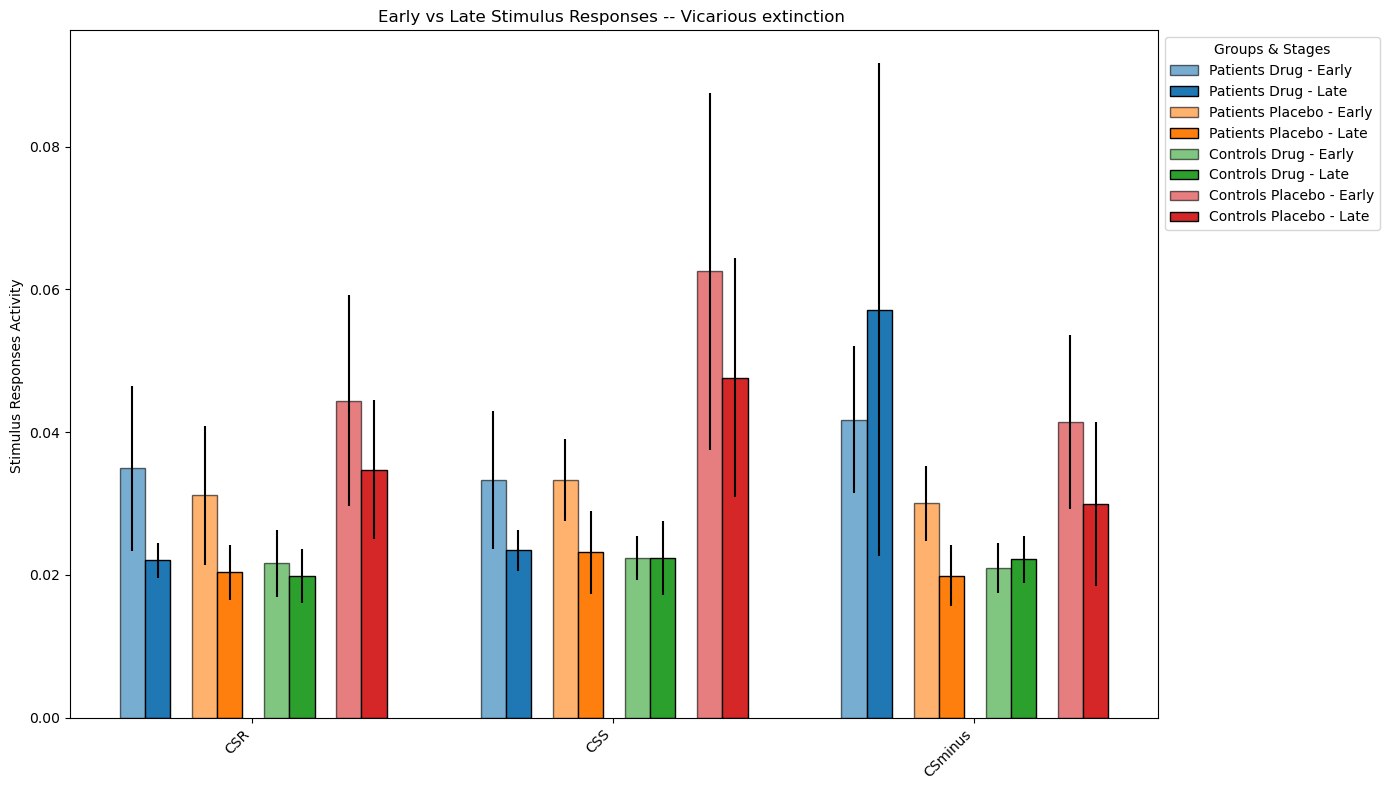

Statistical Test Results:


,Comparison,T-Stat,P-Value
0,patients_drug Early vs Late (CSR),1.069771,0.294554
1,patients_placebo Early vs Late (CSR),1.374439,0.183797
2,controls_drug Early vs Late (CSR),0.423700,0.675721
3,controls_placebo Early vs Late (CSR),1.285625,0.209492
4,Patients Drug vs Placebo (CSR Early),0.241878,0.809927
5,Patients vs Controls Drug (CSR Early),1.022938,0.311361
6,Patients vs Controls Placebo (CSR Early),-0.505081,0.615596
7,Patients Drug vs Placebo (CSR Late),0.381760,0.704360
8,Patients vs Controls Drug (CSR Late),0.500337,0.619078
9,Patients vs Controls Placebo (CSR Late),-1.239893,0.220477


In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            for stage in ['early', 'late']:
                mean, se = all_stats[f'{stimulus}_{group}_{stage}']
                data.append({
                    'Stimulus': stimulus,
                    'Group': group.replace('_', ' ').title(),
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to perform post-hoc t-tests using raw data in all_data
def calculate_posthoc_tests(all_data):
    results = []
    
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            early_values = all_data[f'{stimulus}_{group}_early']
            late_values = all_data[f'{stimulus}_{group}_late']
            t_stat, p_value = ttest_rel(early_values, late_values) if len(early_values) > 1 and len(late_values) > 1 else (np.nan, np.nan)
            results.append({'Comparison': f'{group} Early vs Late ({stimulus})', 'T-Stat': t_stat, 'P-Value': p_value})
        
        for stage in ['early', 'late']:
            patient_drug = all_data[f'{stimulus}_patients_drug_{stage}']
            patient_placebo = all_data[f'{stimulus}_patients_placebo_{stage}']
            control_drug = all_data[f'{stimulus}_controls_drug_{stage}']
            control_placebo = all_data[f'{stimulus}_controls_placebo_{stage}']

            for group_pair, (data1, data2) in {
                'Patients Drug vs Placebo': (patient_drug, patient_placebo),
                'Patients vs Controls Drug': (patient_drug, control_drug),
                'Patients vs Controls Placebo': (patient_drug, control_placebo)
            }.items():
                t_stat, p_value = ttest_ind(data1, data2) if len(data1) > 1 and len(data2) > 1 else (np.nan, np.nan)
                results.append({'Comparison': f'{group_pair} ({stimulus} {stage.capitalize()})', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to plot a multibar plot with error bars and significant annotations
def plot_multibar_with_error_bars(all_stats, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)  # Use all_data for post-hoc tests
    
    plt.figure(figsize=(14, 8))
    stimuli = df['Stimulus'].unique()
    groups = df['Group'].unique()
    width = 0.35  # Width of each bar
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group

    # Plotting for each stimulus category
    for i, stimulus in enumerate(stimuli):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)  # Set x position for each stimulus group
        
        for j, group in enumerate(groups):
            group_data_early = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Early')]
            group_data_late = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Late')]
            
            # Plot bars with error bars
            plt.bar(x_pos[j] - width/2, group_data_early['Mean'].values[0], yerr=group_data_early['SE'].values[0],
                    width=width, color=colors[j], alpha=0.6, edgecolor='black', label=f'{group} - Early' if i == 0 else "")
            plt.bar(x_pos[j] + width/2, group_data_late['Mean'].values[0], yerr=group_data_late['SE'].values[0],
                    width=width, color=colors[j], alpha=1, edgecolor='black', label=f'{group} - Late' if i == 0 else "")

            # Annotate significant differences
            comparison_early_late = f'{group.replace(" ", "_").lower()}_early_vs_late_{stimulus.lower()}'
            if not stats_df[stats_df['Comparison'] == comparison_early_late].empty:
                p_value = stats_df[stats_df['Comparison'] == comparison_early_late]['P-Value'].values[0]
                if p_value < 0.05:
                    y = max(group_data_early['Mean'].values[0] + group_data_early['SE'].values[0],
                            group_data_late['Mean'].values[0] + group_data_late['SE'].values[0]) + 0.1
                    plt.plot([x_pos[j] - width/2, x_pos[j] + width/2], [y, y], color='black')
                    plt.text(x_pos[j], y + 0.05, '*', ha='center', va='bottom', color='black')

    # Customize the plot
    tick_pos = [x + width * 4.25 for x in range(0, len(stimuli) * (len(groups) + 1), len(groups) + 1)]
    plt.xticks(tick_pos, stimuli, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity ')
    plt.title(f'Early vs Late {title} -- Vicarious extinction ')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout()
    plt.show()

    # Display statistical table below the plot
    print("Statistical Test Results:")
    display(stats_df)

# Plot combined multibar plot for all stimulus categories
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, title)


#### Reinstatement

In [164]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack early and late responses with a time variable
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR3_early', 'meanCSR3_late', 'meanCSS3_early', 'meanCSS3_late', 'meanCSminus3_early', 'meanCSminus3_late'], 
                    var_name='stim_type_time', 
                    value_name='response')

# Split 'stim_type_time' into separate 'stim_type' and 'time' columns
long_data['stim_type'] = long_data['stim_type_time'].str.extract(r'mean(\w+)_')[0]
long_data['time'] = long_data['stim_type_time'].str.extract(r'_(\w+)$')[0].map({'early': 0, 'late': 1})

# Map stim_type to numerical codes
long_data['stim_type'] = long_data['stim_type'].map({
    'CSR3': 1, 
    'CSS3': 2, 
    'CSminus3': 3
})

# Specify the model with time as a main effect
model_formula = 'response ~ patient_group * drug + stim_type + time + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     8.867
Date:                Fri, 01 Nov 2024   Prob (F-statistic):           2.77e-09
Time:                        09:51:04   Log-Likelihood:                 628.17
No. Observations:                 606   AIC:                            -1242.
Df Residuals:                     599   BIC:                            -1211.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0745      0

In [145]:
import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx",'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)

# Initialize dictionary to store means and SEs
all_stats = {}

# Calculate means and SEs for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Early stage statistics for CSS2
    mean_early = group_data['meanCSS3_early'].mean()
    se_early = group_data['meanCSS3_early'].sem()
    all_stats[f'CSS_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSS2
    mean_late = group_data['meanCSS3_late'].mean()
    se_late = group_data['meanCSS3_late'].sem()
    all_stats[f'CSS_{group}_late'] = (mean_late, se_late)

    # Early stage statistics for CSR2
    mean_early = group_data['meanCSR3_early'].mean()
    se_early = group_data['meanCSR3_early'].sem()
    all_stats[f'CSR_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSR2
    mean_late = group_data['meanCSR3_late'].mean()
    se_late = group_data['meanCSR3_late'].sem()
    all_stats[f'CSR_{group}_late'] = (mean_late, se_late)

    # Early stage statistics for CSR2
    mean_early = group_data['meanCSminus3_early'].mean()
    se_early = group_data['meanCSminus3_early'].sem()
    all_stats[f'CSminus_{group}_early'] = (mean_early, se_early)
    
    # Late stage statistics for CSR2
    mean_late = group_data['meanCSminus3_late'].mean()
    se_late = group_data['meanCSminus3_late'].sem()
    all_stats[f'CSminus_{group}_late'] = (mean_late, se_late)

import pandas as pd

# Load drug_order Excel sheet
drug_order = pd.read_excel("drug_order.xlsx", 'drug_order')  # Adjust the path if necessary

# Merge dat_df with drug_order based on subID
data = pd.merge(dat_df, drug_order[['subID', 'drug_condition']], on='subID', how='left')

# Define groups based on subID and drugorder
data['Group'] = data.apply(
    lambda row: (
        'patients_drug' if row['subID'].startswith('N1') and row['drug_condition'] == 1 else
        'patients_placebo' if row['subID'].startswith('N1') and row['drug_condition'] == 0 else
        'controls_drug' if row['subID'].startswith('N2') and row['drug_condition'] == 1 else
        'controls_placebo'
    ), axis=1
)

# Initialize dictionary to store all data
all_data = {}

# Populate all_data with raw data for each group and stage
for group in data['Group'].unique():
    group_data = data[data['Group'] == group]
    
    # Store early and late stage data for each stimulus type
    all_data[f'CSS_{group}_early'] = group_data['meanCSS3_early'].values
    all_data[f'CSS_{group}_late'] = group_data['meanCSS3_late'].values
    all_data[f'CSR_{group}_early'] = group_data['meanCSR3_early'].values
    all_data[f'CSR_{group}_late'] = group_data['meanCSR3_late'].values
    all_data[f'CSminus_{group}_early'] = group_data['meanCSminus3_early'].values
    all_data[f'CSminus_{group}_late'] = group_data['meanCSminus3_late'].values



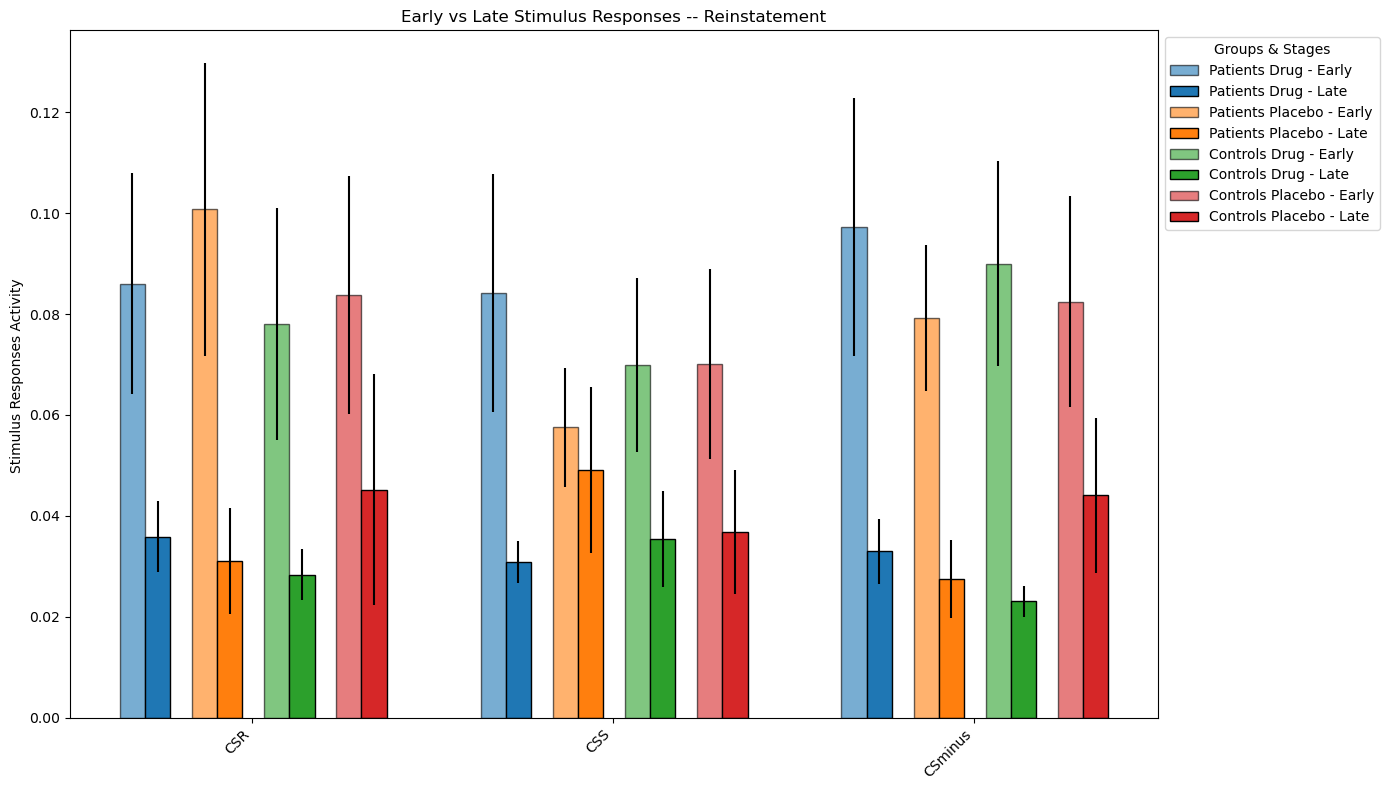

Statistical Test Results:


,Comparison,T-Stat,P-Value
0,patients_drug Early vs Late (CSR),2.982987,0.006133
1,patients_placebo Early vs Late (CSR),2.948044,0.007680
2,controls_drug Early vs Late (CSR),2.153339,0.042013
3,controls_placebo Early vs Late (CSR),1.512791,0.141951
4,Patients Drug vs Placebo (CSR Early),-0.412869,0.681580
5,Patients vs Controls Drug (CSR Early),0.252599,0.801635
6,Patients vs Controls Placebo (CSR Early),0.067871,0.946143
7,Patients Drug vs Placebo (CSR Late),0.394499,0.694997
8,Patients vs Controls Drug (CSR Late),0.850980,0.398920
9,Patients vs Controls Placebo (CSR Late),-0.381424,0.704414


In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            for stage in ['early', 'late']:
                mean, se = all_stats[f'{stimulus}_{group}_{stage}']
                data.append({
                    'Stimulus': stimulus,
                    'Group': group.replace('_', ' ').title(),
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to perform post-hoc t-tests using raw data in all_data
def calculate_posthoc_tests(all_data):
    results = []
    
    for stimulus in ['CSR', 'CSS', 'CSminus']:
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            early_values = all_data[f'{stimulus}_{group}_early']
            late_values = all_data[f'{stimulus}_{group}_late']
            t_stat, p_value = ttest_rel(early_values, late_values) if len(early_values) > 1 and len(late_values) > 1 else (np.nan, np.nan)
            results.append({'Comparison': f'{group} Early vs Late ({stimulus})', 'T-Stat': t_stat, 'P-Value': p_value})
        
        for stage in ['early', 'late']:
            patient_drug = all_data[f'{stimulus}_patients_drug_{stage}']
            patient_placebo = all_data[f'{stimulus}_patients_placebo_{stage}']
            control_drug = all_data[f'{stimulus}_controls_drug_{stage}']
            control_placebo = all_data[f'{stimulus}_controls_placebo_{stage}']

            for group_pair, (data1, data2) in {
                'Patients Drug vs Placebo': (patient_drug, patient_placebo),
                'Patients vs Controls Drug': (patient_drug, control_drug),
                'Patients vs Controls Placebo': (patient_drug, control_placebo)
            }.items():
                t_stat, p_value = ttest_ind(data1, data2) if len(data1) > 1 and len(data2) > 1 else (np.nan, np.nan)
                results.append({'Comparison': f'{group_pair} ({stimulus} {stage.capitalize()})', 'T-Stat': t_stat, 'P-Value': p_value})
    
    return pd.DataFrame(results)

# Function to plot a multibar plot with error bars and significant annotations
def plot_multibar_with_error_bars(all_stats, title):
    df = prepare_data_for_multibar_plot(all_stats)
    stats_df = calculate_posthoc_tests(all_data)  # Use all_data for post-hoc tests
    
    plt.figure(figsize=(14, 8))
    stimuli = df['Stimulus'].unique()
    groups = df['Group'].unique()
    width = 0.35  # Width of each bar
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group

    # Plotting for each stimulus category
    for i, stimulus in enumerate(stimuli):
        x_pos = np.arange(len(groups)) + i * (len(groups) + 1)  # Set x position for each stimulus group
        
        for j, group in enumerate(groups):
            group_data_early = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Early')]
            group_data_late = df[(df['Stimulus'] == stimulus) & (df['Group'] == group) & (df['Stage'] == 'Late')]
            
            # Plot bars with error bars
            plt.bar(x_pos[j] - width/2, group_data_early['Mean'].values[0], yerr=group_data_early['SE'].values[0],
                    width=width, color=colors[j], alpha=0.6, edgecolor='black', label=f'{group} - Early' if i == 0 else "")
            plt.bar(x_pos[j] + width/2, group_data_late['Mean'].values[0], yerr=group_data_late['SE'].values[0],
                    width=width, color=colors[j], alpha=1, edgecolor='black', label=f'{group} - Late' if i == 0 else "")

            # Annotate significant differences
            comparison_early_late = f'{group.replace(" ", "_").lower()}_early_vs_late_{stimulus.lower()}'
            if not stats_df[stats_df['Comparison'] == comparison_early_late].empty:
                p_value = stats_df[stats_df['Comparison'] == comparison_early_late]['P-Value'].values[0]
                if p_value < 0.05:
                    y = max(group_data_early['Mean'].values[0] + group_data_early['SE'].values[0],
                            group_data_late['Mean'].values[0] + group_data_late['SE'].values[0]) + 0.1
                    plt.plot([x_pos[j] - width/2, x_pos[j] + width/2], [y, y], color='black')
                    plt.text(x_pos[j], y + 0.05, '*', ha='center', va='bottom', color='black')

    # Customize the plot
    tick_pos = [x + width * 4.25 for x in range(0, len(stimuli) * (len(groups) + 1), len(groups) + 1)]
    plt.xticks(tick_pos, stimuli, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity ')
    plt.title(f'Early vs Late {title} -- Reinstatement')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout()
    plt.show()

    # Display statistical table below the plot
    print("Statistical Test Results:")
    display(stats_df)

# Plot combined multibar plot for all stimulus categories
title = 'Stimulus Responses'
plot_multibar_with_error_bars(all_stats, title)


## Peak-base, z-scored SCR value

z-scoring on an individual level basis -- trial peak-base - mean(all 24 trials) / mean(all trial trials)  -- doesn't look correct 


### Phase 1

In [184]:
import os
import pandas as pd
import numpy as np

# Set the working directory
path = '/Volumes/Seagate Desktop Drive/NARSAD/SCR'
os.chdir(path)

# Parameters
trialnumber = range(1, 25)  # Adjust to the first half of trials if needed
excludeparticipants = 1  # Set to 0 to include all participants
rejtrials_threshold = 24  # Adjust the threshold as needed

# Load the table
peakstatstable = pd.read_csv('peak_stats_table-phase1.csv')

# Extract unique participant IDs and trial types
participants = peakstatstable['sid'].unique()

# Add a group column based on participant IDs if needed
# This step assumes that participant IDs indicate their group. Adjust as necessary.
peakstatstable['group'] = np.where(peakstatstable['sid'].str.startswith('N1'), 'patient', 'control')  # Modify as needed

# Group data by participant
participant_groups = peakstatstable.groupby('sid')
dat = []

for participant_id in participants:
    data = participant_groups.get_group(participant_id)
    subject_data = {'subID': participant_id}

    # Process data if there are 24 trials
    if len(data) == 24:
        phase1_data = data[data['stNum'].isin(trialnumber)]

        # Rejected trials (based on "Publication recommendations for electrodermal measurements")
        rejTrials = phase1_data[phase1_data['phaBase2Peak'] < 0].index
        phase1_data.loc[rejTrials, 'phaBase2Peak'] = 0  # Mark non-response trials as 0

        subject_data['rejTrials1'] = len(rejTrials)

        # Calculate participant-wise average and standard deviation
        participant_mean = phase1_data['phaBase2Peak'].mean()
        participant_std = phase1_data['phaBase2Peak'].std()

        # Separate data by stim type
        stim_groups = phase1_data.groupby('stTy')

        try:
            # Z-score the phaBase2Peak values for each stimulus type
            for stim_type, stim_data in stim_groups:
                # Calculate z-scores based on participant's mean and std
                z_scores = (stim_data['phaBase2Peak'] - participant_mean) / participant_std
                
                # Store the mean and SE of z-scores with the new variable names
                if stim_type == 'CS+S':
                    subject_data['meanCSS1'] = z_scores.mean()
                    subject_data['seCSS1'] = z_scores.std() / np.sqrt(len(z_scores))
                    subject_data['nCSS1'] = len(z_scores)
                elif stim_type == 'CS+R':
                    subject_data['meanCSR1'] = z_scores.mean()
                    subject_data['seCSR1'] = z_scores.std() / np.sqrt(len(z_scores))
                    subject_data['nCSR1'] = len(z_scores)
                elif stim_type == 'CS-':
                    subject_data['meanCSminus1'] = z_scores.mean()
                    subject_data['seCSminus1'] = z_scores.std() / np.sqrt(len(z_scores))
                    subject_data['nCSminus1'] = len(z_scores)

        except KeyError:
            print(f"Missing stim type data for participant {participant_id}")

    dat.append(subject_data)

# Convert to a DataFrame if you need a structured output
dat_df = pd.DataFrame(dat)

print(dat_df)


    subID  rejTrials1  meanCSR1    seCSR1  nCSR1  meanCSS1    seCSS1  nCSS1  \
0    N101           4 -0.191597  0.201230      8  0.461885  0.549469      8   
1    N102           0 -0.488130  0.104743      8  0.488130  0.552979      8   
2    N103           1  0.086566  0.364331      8 -0.120133  0.294204      8   
3    N104           5 -0.321006  0.131551      8 -0.207710  0.213842      8   
4    N105           2 -0.392065  0.196368      8  0.208545  0.389419      8   
..    ...         ...       ...       ...    ...       ...       ...    ...   
99   N255           6 -0.337741  0.094990      8 -0.369404  0.086299      8   
100  N257           4  0.093319  0.490107      8 -0.118077  0.235745      8   
101  N258           0 -0.079173  0.421012      8  0.200262  0.390068      8   
102  N259           2  0.336829  0.523763      8 -0.007322  0.275650      8   
103  N260           1 -0.106682  0.246396      8  0.109453  0.421726      8   

     meanCSminus1  seCSminus1  nCSminus1  
0   -2.7

#### CSR, CSS kept separate 

In [185]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 1, 
    'meanCSS1': 2, 
    'meanCSminus1': 3
})

# Specify the model without intercept
model_formula = 'response ~ patient_group * stim_type + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.1637
Date:                Fri, 01 Nov 2024   Prob (F-statistic):              0.957
Time:                        12:42:04   Log-Likelihood:                -45.897
No. Observations:                 312   AIC:                             101.8
Df Residuals:                     307   BIC:                             120.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_60532/4197659941.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long_data['stim_type'] = long_data['stim_type'].replace({


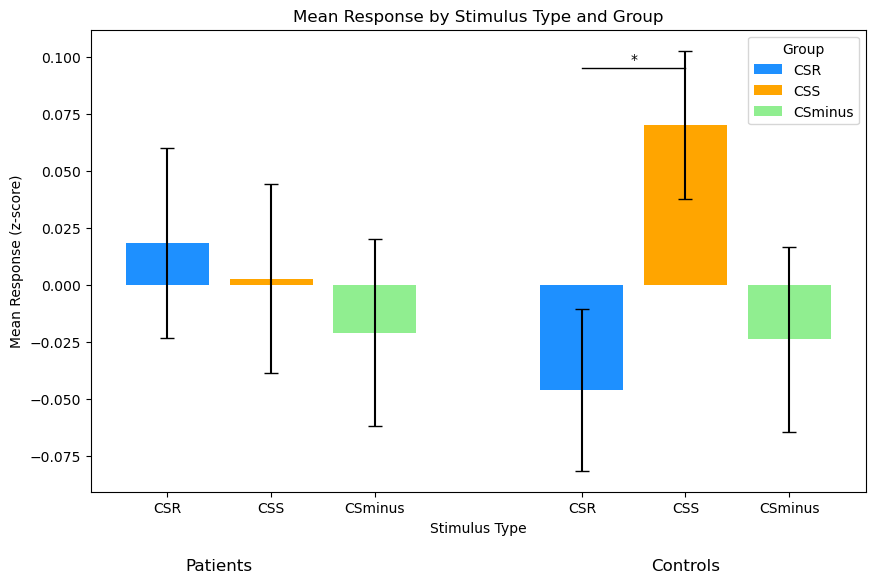

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 'CSR', 
    'meanCSS1': 'CSS', 
    'meanCSminus1': 'CSminus'
})

# Calculate means and errors
group_means = long_data.groupby(['patient_group', 'stim_type'])['response'].mean().reset_index()
group_sems = long_data.groupby(['patient_group', 'stim_type'])['response'].sem().reset_index()

# Set up custom x positions for the bars (grouped with a gap between patients and controls)
x_positions = {
    ('patient', 'CSR'): 0, ('patient', 'CSS'): 1, ('patient', 'CSminus'): 2,
    ('control', 'CSR'): 4, ('control', 'CSS'): 5, ('control', 'CSminus'): 6
}

# Map x positions to data
group_means['x'] = group_means.apply(lambda row: x_positions[(row['patient_group'], row['stim_type'])], axis=1)
group_sems['x'] = group_means['x']

# Define colors for each stimulus type
stimulus_colors = {
    'CSR': 'dodgerblue',
    'CSS': 'orange',
    'CSminus': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(10, 6))

for group in ['patient', 'control']:
    for stim in ['CSR', 'CSS', 'CSminus']:
        group_data = group_means[(group_means['patient_group'] == group) & (group_means['stim_type'] == stim)]
        group_errors = group_sems[(group_sems['patient_group'] == group) & (group_sems['stim_type'] == stim)]
        plt.bar(group_data['x'], group_data['response'], 
                color=stimulus_colors[stim], 
                label=stim if group == 'patient' else "",  # Label only for patients
                yerr=group_errors['response'], capsize=5)

# Add significance markers
def add_significance_markers(ax, comparisons, y_offset=0.02, bar_height=0.02):
    for (group1, stim1), (group2, stim2) in comparisons:
        if group1 == group2:
            # Paired t-test within the same group
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_rel(data1['response'], data2['response'])
        else:
            # Independent t-test between groups
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group2) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_ind(data1['response'], data2['response'], equal_var=False)
        
        if result.pvalue < 0.05:  # Customize significance level if needed
            x1 = x_positions[(group1, stim1)]
            x2 = x_positions[(group2, stim2)]
            max_y = group_means['response'].max() + 0.025  # Adjust this if needed
            ax.plot([x1, x2], [max_y, max_y], 'k-', lw=1)
            ax.text((x1 + x2) / 2, max_y + 0.001, '*', ha='center', va='bottom')

# Define comparisons
comparisons = [
    (('patient', 'CSR'), ('patient', 'CSS')),   # Patient CSR vs CSS
    (('patient', 'CSR'), ('patient', 'CSminus')),  # Patient CSR vs CSminus
    (('patient', 'CSS'), ('patient', 'CSminus')),  # Patient CSS vs CSminus
    (('control', 'CSR'), ('control', 'CSS')),   # Control CSR vs CSS
    (('control', 'CSR'), ('control', 'CSminus')),  # Control CSR vs CSminus
    (('control', 'CSS'), ('control', 'CSminus')),  # Control CSS vs CSminus
    (('patient', 'CSR'), ('control', 'CSR')),    # Between-group CSR
    (('patient', 'CSS'), ('control', 'CSS')),    # Between-group CSS
    (('patient', 'CSminus'), ('control', 'CSminus')) # Between-group CSminus
]

add_significance_markers(plt.gca(), comparisons)
# Add x-axis labels to indicate groups
plt.text(0.5, -0.12, 'Patients', ha='center', va='top', fontsize=12)
plt.text(5, -0.12, 'Controls', ha='center', va='top', fontsize=12)

# Labeling and finalizing plot
plt.xticks([0, 1, 2, 4, 5, 6], ['CSR', 'CSS', 'CSminus', 'CSR', 'CSS', 'CSminus'])
plt.xlabel('Stimulus Type')
plt.ylabel('Mean Response (z-score)')
plt.title('Mean Response by Stimulus Type and Group')
plt.legend(title='Group')
plt.show()


#### CS+ vs CS- 

In [192]:
## treating CSR and CSS as the same categorical condition 

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 1, 0)  # 1 for patient, 0 for control
merged_data['gender'] = merged_data['gender_code']  # Gender as categorical
merged_data['drug'] = merged_data['drug_condition']  # Drug as categorical

# Reshape data to stack meanCSR1, meanCSS1, and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group', 'drug', 'gender'], 
                    value_vars=['meanCSR1', 'meanCSS1', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Combine CSR and CSS into a single variable called CS+
long_data['stim_type'] = long_data['stim_type'].replace({
    'meanCSR1': 'CS+',  # Combine CSR
    'meanCSS1': 'CS+',  # Combine CSS
    'meanCSminus1': 'CSminus'  # Keep CSminus as is
})

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].astype('category')

# Specify the model without intercept
model_formula = 'response ~ patient_group * stim_type + gender'

# Fit the model
model = smf.ols(formula=model_formula, data=long_data).fit()

# Display the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.2494
Date:                Fri, 01 Nov 2024   Prob (F-statistic):              0.910
Time:                        12:44:31   Log-Likelihood:                -45.723
No. Observations:                 312   AIC:                             101.4
Df Residuals:                     307   BIC:                             120.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

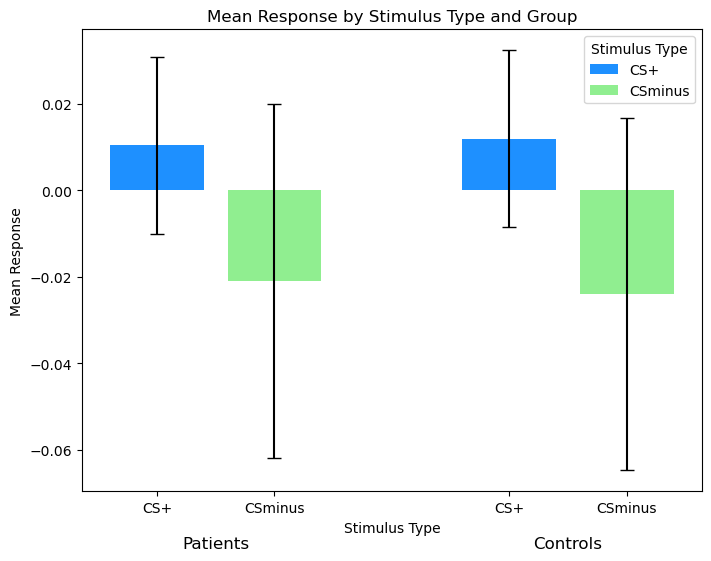

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming 'dat' is a list of dictionaries created in the first code, convert it to a DataFrame
dat_df = pd.DataFrame(dat)

# Load the drug assignment and gender data
drug_order = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')

# Merge 'dat_df' with 'drug_order' based on subject ID
merged_data = pd.merge(dat_df, drug_order, left_on='subID', right_on='subID', how='inner')

# Prepare columns for the analysis
merged_data['patient_group'] = np.where(merged_data['subID'].str.startswith('N1'), 'patient', 'control')

# Calculate the mean of CSR and CSS for each subject to create CS+
merged_data['CS_plus'] = merged_data[['meanCSR1', 'meanCSS1']].mean(axis=1)

# Reshape data to stack CS_plus and meanCSminus1 as a single column with stim_type as a category
long_data = pd.melt(merged_data, 
                    id_vars=['subID', 'patient_group'], 
                    value_vars=['CS_plus', 'meanCSminus1'], 
                    var_name='stim_type', 
                    value_name='response')

# Map stim_type to categorical labels
long_data['stim_type'] = long_data['stim_type'].replace({
    'CS_plus': 'CS+', 
    'meanCSminus1': 'CSminus'
})

# Calculate means and errors
group_means = long_data.groupby(['patient_group', 'stim_type'])['response'].mean().reset_index()
group_sems = long_data.groupby(['patient_group', 'stim_type'])['response'].sem().reset_index()

# Set up custom x positions for the bars (grouped with a gap between patients and controls)
x_positions = {
    ('patient', 'CS+'): 0, ('patient', 'CSminus'): 1,
    ('control', 'CS+'): 3, ('control', 'CSminus'): 4
}

# Map x positions to data
group_means['x'] = group_means.apply(lambda row: x_positions[(row['patient_group'], row['stim_type'])], axis=1)
group_sems['x'] = group_means['x']

# Define colors for each stimulus type
stimulus_colors = {
    'CS+': 'dodgerblue',
    'CSminus': 'lightgreen'
}

# Plot bar chart
plt.figure(figsize=(8, 6))

for group in ['patient', 'control']:
    for stim in ['CS+', 'CSminus']:
        group_data = group_means[(group_means['patient_group'] == group) & (group_means['stim_type'] == stim)]
        group_errors = group_sems[(group_sems['patient_group'] == group) & (group_sems['stim_type'] == stim)]
        plt.bar(group_data['x'], group_data['response'], 
                color=stimulus_colors[stim], 
                label=stim if group == 'patient' else "",  # Label only for patients
                yerr=group_errors['response'], capsize=5)

# Add significance markers
def add_significance_markers(ax, comparisons, y_offset=0.02, bar_height=0.02):
    for (group1, stim1), (group2, stim2) in comparisons:
        if group1 == group2:
            # Paired t-test within the same group
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_rel(data1['response'], data2['response'])
        else:
            # Independent t-test between groups
            data1 = long_data[(long_data['patient_group'] == group1) & (long_data['stim_type'] == stim1)]
            data2 = long_data[(long_data['patient_group'] == group2) & (long_data['stim_type'] == stim2)]
            result = stats.ttest_ind(data1['response'], data2['response'], equal_var=False)
        
        if result.pvalue < 0.05:  # Customize significance level if needed
            x1 = x_positions[(group1, stim1)]
            x2 = x_positions[(group2, stim2)]
            max_y = group_means['response'].max() + 0.025  # Adjust this if needed
            ax.plot([x1, x2], [max_y, max_y], 'k-', lw=1)
            ax.text((x1 + x2) / 2, max_y + 0.001, '*', ha='center', va='bottom')

# Define comparisons
comparisons = [
    (('patient', 'CS+'), ('patient', 'CSminus')),   # Patient CS+ vs CSminus
    (('control', 'CS+'), ('control', 'CSminus')),   # Control CS+ vs CSminus
    (('patient', 'CS+'), ('control', 'CS+')),       # Between-group CS+
    (('patient', 'CSminus'), ('control', 'CSminus')) # Between-group CSminus
]

add_significance_markers(plt.gca(), comparisons)

# Labeling and finalizing plot
plt.xticks([0, 1, 3, 4], ['CS+', 'CSminus', 'CS+', 'CSminus'])
plt.xlabel('Stimulus Type')
plt.ylabel('Mean Response')
plt.title('Mean Response by Stimulus Type and Group')

# Add x-axis labels to indicate groups
plt.text(0.5, -0.08, 'Patients', ha='center', va='top', fontsize=12)
plt.text(3.5, -0.08, 'Controls', ha='center', va='top', fontsize=12)

plt.legend(title='Stimulus Type')
plt.show()
